# Homework 2: Neural Language Modeling

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install jsonlines

In [0]:
import os
import json
import jsonlines
import numpy as np
from collections import defaultdict

## I. N-Gram Language Modeling

#### Utilities

In [0]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [0]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [0]:
datasets, vocab = load_wikitext()

delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

Vocab size: 33175
Baseline (Additive smoothing, n=2, delta=0.0005)) Train Perplexity: 90.228
Baseline (Additive smoothing, n=2, delta=0.0005)) Valid Perplexity: 525.825
Baseline (Additive smoothing, n=3, delta=0.0005)) Train Perplexity: 26.768
Baseline (Additive smoothing, n=3, delta=0.0005)) Valid Perplexity: 2577.128
Baseline (Additive smoothing, n=4, delta=0.0005)) Train Perplexity: 19.947
Baseline (Additive smoothing, n=4, delta=0.0005)) Valid Perplexity: 9570.901


### I.1 Interpolation

In [0]:
class NGramInterpolation(object):
    def __init__(self, n, vsize, Lambda):
        self.n = n
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
        self.Lambda = Lambda
        self.ngram_list = []
        self.prefix_list = []
    
    def estimate(self, sequences):
        for l in range(1, self.n+1):
            for sequence in sequences:
                padded_sequence = ['<bos>']*(l-1) + sequence + ['<eos>']
                for i in range(len(padded_sequence) - l+1):
                    ngram = tuple(padded_sequence[i:i+l])
                    self.ngram_list.append(ngram)
                    prefix, word = ngram[:-1], ngram[-1]
                    self.prefix_list.append(prefix)
                    self.count[prefix][word] += 1
                    self.total[prefix] += 1
            #print(len(self.ngram_list), self.ngram_list[0], self.ngram_list[-1], len(self.prefix_list), self.prefix_list[0], self.prefix_list[-1])
                

    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prob = 0
        for i in range(self.n+1):
            if i == 0:
                prob += self.Lambda[i] * (1/self.vsize)
            else:
                prefix = ngram[i-1:-1]
                word = ngram[-1]
                prob += self.Lambda[i]*(self.count[prefix][word] / max(self.total[prefix], 1))
        return prob



#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [0]:
perplexity_train = []
perplexity_val = []

In [0]:
for n in [2, 3, 4]:
    if n == 2:
        Lambda = [0.2, 0.3, 0.5]
    elif n == 3:
        Lambda = [0.1, 0.1, 0.3, 0.5]
    elif n == 4:
        Lambda = [0.05, 0.05, 0.1, 0.3, 0.5]
    
    lm = NGramInterpolation(n=n, vsize=len(vocab)+1, Lambda=Lambda)
    lm.estimate(datasets['train'])
    p_train = perplexity(lm, datasets['train'])
    p_val = perplexity(lm, datasets['valid'])
    perplexity_train.append(p_train)
    perplexity_val.append(p_val)

    print("Result (Interpolation smoothing, n=%d, lambda=%s)) Train Perplexity: %.3f" % (n, str(Lambda), p_train))
    print("Result (Interpolation smoothing, n=%d, lambda=%s)) Valid Perplexity: %.3f" % (n, str(Lambda), p_val))

Result (Interpolation smoothing, n=2, lambda=[0.2, 0.3, 0.5])) Train Perplexity: 183.713
Result (Interpolation smoothing, n=2, lambda=[0.2, 0.3, 0.5])) Valid Perplexity: 386.290
Result (Interpolation smoothing, n=3, lambda=[0.1, 0.1, 0.3, 0.5])) Train Perplexity: 39.441
Result (Interpolation smoothing, n=3, lambda=[0.1, 0.1, 0.3, 0.5])) Valid Perplexity: 314.132
Result (Interpolation smoothing, n=4, lambda=[0.05, 0.05, 0.1, 0.3, 0.5])) Train Perplexity: 16.335
Result (Interpolation smoothing, n=4, lambda=[0.05, 0.05, 0.1, 0.3, 0.5])) Valid Perplexity: 305.984


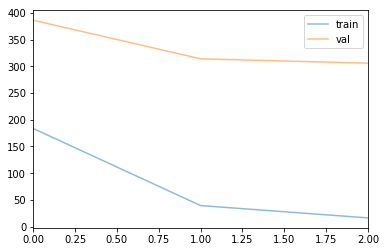

In [0]:
import pandas as pd
perplexity_df = pd.DataFrame({
    "train": perplexity_train,
    "val": perplexity_val,
})
perplexity_df.plot(alpha=0.5)

### I.2 Extra Credit: Kneser-Ney Smoothing

In this part, we adopt modified Kneser-Ney Smoothing in our n-gram model.

The probability calculation takes the sectioned function form in lecture note:

![替代文字](https://campuspro-uploads.s3.us-west-2.amazonaws.com/73ed3c96-f47b-47b3-8300-1d13778b0d12/5b40739f-2c5c-4dda-b040-f540ecf19365/图片%204.png)

where γ is 

![替代文字](https://campuspro-uploads.s3.us-west-2.amazonaws.com/73ed3c96-f47b-47b3-8300-1d13778b0d12/d095ac2c-b319-4515-9f94-5ad320d601af/图片%205.png)

where N() is defined as

![替代文字](https://campuspro-uploads.s3.us-west-2.amazonaws.com/73ed3c96-f47b-47b3-8300-1d13778b0d12/ab49e91e-24c4-4780-8a82-18b4a21b1cb1/图片%201.png)

When the words are not in our dictionary, we regard the probability as 1/|vocab|, i.e. consider the distribution as uniform.

In [0]:
class NGramKneserNey(object):
    def __init__(self, n, vsize):
        self.n = n
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.ngram_count = defaultdict(float)
        self.vsize = vsize
        self.y = 0
        self.discounts = []
        
    def ngram_number(self, times):
        ngram_number = 0
        #print(len(list(self.count.values())))
        values = list(self.ngram_count.values())
        ngram_number = int(values.count(times))
        return ngram_number
            
    def discounting(self, count_number):
        if count_number<3:
            c = count_number
        else:
            c = 3
        y = self.ngram_number(1)/(self.ngram_number(1)+2*self.ngram_number(2))
        d = c - (c+1)*y*(self.ngram_number(c+1)/self.ngram_number(c))
        return d
    
    def possible_words_number(self, prefix, times):
        possible_words_number = 0
        if times<3:
            values = list(self.count[prefix].values())
            #print(self.count[prefix])
            #print(values)
            possible_words_number = int(values.count(times))
        if times == 3:
            values = list(self.count[prefix].values())
            #print(self.count[prefix])
            #print(values)
            possible_words_number = len(values) - int(values.count(0)) - int(values.count(1)) - int(values.count(2))
        #print('N', times, '=', possible_words_number)
        return possible_words_number

    def estimate(self, sequences):
        for m in range(1, self.n+1):
            for sequence in sequences:
                padded_sequence = ['<bos>']*(m-1) + sequence + ['<eos>']
                for i in range(len(padded_sequence) - m+1):
                    ngram = tuple(padded_sequence[i:i+m])
                    prefix, word = ngram[:-1], ngram[-1]
                    self.count[prefix][word] += 1
                    self.total[prefix] += 1
                    self.ngram_count[ngram] +=1
        #print(list(self.ngram_count)[:10], list(self.ngram_count)[-10:])
        #print(list(self.total)[:10], list(self.total)[-10:])
        #print(len(list(self.total)))
        #print(len(list(self.ngram_count)))
        #print('===================ESTIMATE====================')

                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            #print(i)
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        if len(ngram) == 0:
                #print('0-th distribution prob', (1/self.vsize))
                return 1/self.vsize
            
        else: 
            prefix = ngram[:-1]
            word = ngram[-1]
            if self.count[prefix][word] >0:
                assert self.total[prefix] > 0
                
                if self.count[prefix][word] ==1:
                    discount = self.discounts[0]
                elif self.count[prefix][word] ==2:
                    discount = self.discounts[1]
                elif self.count[prefix][word] >2:
                    discount = self.discounts[2]
                    
                alpha = (self.count[prefix][word] - discount)/self.total[prefix]
                prob = alpha
                #print(prob)
                return prob
            
            else:
                if self.total[prefix] == 0:
                    gamma= (self.discounts[0]*self.possible_words_number(prefix, 1)+self.discounts[1]*self.possible_words_number(prefix, 2)+\
                         self.discounts[2]*self.possible_words_number(prefix, 3))/1
                    assert gamma == 0
                    return 1/self.vsize
                else:
                    gamma = (self.discounts[0]*self.possible_words_number(prefix, 1)+self.discounts[1]*self.possible_words_number(prefix, 2)+\
                         self.discounts[2]*self.possible_words_number(prefix, 3))/self.total[prefix]

                #print('Recursive---------------------------------------------------------')
                return gamma*self.ngram_prob(ngram[1:])

In [0]:
datasets, vocab = load_wikitext()

for n in [2, 3, 4]:
    lm = NGramKneserNey(n=n,vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])
    n_1 = lm.ngram_number(1)
    n_2 = lm.ngram_number(2)
    n_3 = lm.ngram_number(3)
    n_4 = lm.ngram_number(4)
    ngram_number = [n_1, n_2, n_3, n_4]
    #print(ngram_number)
    lm.y = n_1/(n_1+2*n_2)
    #print(lm.y)
    d_1 = 1 - 2*lm.y*(n_2/n_1)
    d_2 = 2 - 3*lm.y*(n_3/n_2)
    d_3_plus = 3 - 4*lm.y*(n_4/n_3)
    lm.discounts = [d_1, d_2, d_3_plus]
    #print(lm.discounts)
    print("Result (modified Knesey-Ney Smoothing, n=%d) Train Perplexity: %.3f" % (n, perplexity(lm, datasets['train'])))
    print("Result (modified Knesey-Ney Smoothing, n=%d)) Valid Perplexity: %.3f" % (n, perplexity(lm, datasets['valid'])))

Vocab size: 33175
Result (modified Knesey-Ney Smoothing, n=2) Train Perplexity: 114.984
Result (modified Knesey-Ney Smoothing, n=2)) Valid Perplexity: 307.824
Result (modified Knesey-Ney Smoothing, n=3) Train Perplexity: 22.978
Result (modified Knesey-Ney Smoothing, n=3)) Valid Perplexity: 861.531
Result (modified Knesey-Ney Smoothing, n=4) Train Perplexity: 11.778
Result (modified Knesey-Ney Smoothing, n=4)) Valid Perplexity: 4992.278


According to the results, train perplexities are significantly lower than that of additive smoothing or of interpolation smoothing. But the validation perplexity, though lower than additive smoothing, is higher than that of our interpolation smoothing. 

## II. Neural Language Modeling with a Recurrent Neural Network

In [0]:
import torch
import torch.nn as nn

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

##### Dictionary

In [0]:
import sys

try:
    import jsonlines
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install jsonlines
  
try:
    from tqdm import tqdm
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install tqdm
  
import os
    


class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

 ##### Dataset loading

In [0]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [0]:
# this function slices the input sequence into ngrams i.e.
# [0,1,2,3,4,5] will be sliced into bigrams
# [0,1], [1,2], [2,3], [3,4], [4,5] etc for bigger orders

def slice_sequences_given_order(tokenized_dataset_with_spec, ngram_order=5):
    sliced_datasets = {}
    for split, dataset in tokenized_dataset_with_spec.items():
        _list_of_sliced_ngrams = []
        for seq in tqdm(dataset):
            ngrams = [seq[i:i+ngram_order] for i in range(len(seq)-ngram_order+1)]
            _list_of_sliced_ngrams.extend(ngrams)
        sliced_datasets[split] = _list_of_sliced_ngrams

    return sliced_datasets

In [0]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab
  
  
# wiki_dataset, vocab = load_wikitext()

# print(wiki_dataset['train'][1])

In [0]:
wiki_dataset, wiki_dict_ori = load_wikitext()

wiki_dict = Dictionary(wiki_dataset, include_valid=True)

# checking some example
print(' '.join(wiki_dataset['train'][3010]))

encoded = wiki_dict.encode_token_seq(wiki_dataset['train'][3010])
print(f'\n encoded - {encoded}')
decoded = wiki_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

# personachat_tokenized_datasets_5gram = tokenize_dataset(wiki_dataset, wiki_dict, ngram_order=5)

--2019-10-08 23:42:16--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 185.235.236.197
Connecting to nyu.box.com (nyu.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-08 23:42:16--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-08 23:42:16--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 185.235.236.199
Connecting to nyu.app.box.com (nyu.app.box.com)|185.235.236.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.

  1%|          | 467/78274 [00:00<00:16, 4664.63it/s]

Vocab size: 33175


100%|██████████| 8464/8464 [00:10<00:00, 792.23it/s]

The Nataraja and Ardhanarishvara sculptures are also attributed to the Rashtrakutas .

 encoded - [75, 8816, 30, 8817, 8732, 70, 91, 2960, 13, 6, 8806, 39]

 decoded - ['The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.']


In [0]:
print(' '.join(wiki_dataset['train'][3010]))
encoded = wiki_dict.encode_token_seq(wiki_dataset['train'][3010])
print(f'\n encoded - {encoded}')
decoded = wiki_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

print(len(wiki_dict))

The Nataraja and Ardhanarishvara sculptures are also attributed to the Rashtrakutas .

 encoded - [75, 8816, 30, 8817, 8732, 70, 91, 2960, 13, 6, 8806, 39]

 decoded - ['The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.']
33181


##### RNN baseline

In [0]:
import torch.nn as nn

class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [0]:
import os 

if not os.path.exists('/content/drive/My Drive/nlp2_save_model'):
  os.mkdir('/content/drive/My Drive/nlp2_save_model')

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import os

# creating a LSTM model, criterion and optimizer


# create the model folder
epoch_num = 0
load_pretrained = False


num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'
    
    
    

if load_pretrained:
    # input the epoch num you want to continue based on
    epoch_num = 0
    
    embedding_size = 256
    hidden_size = 512
    num_layers = 3
    rnn_dropout = 0.3

    model_predix = model_predix = '1002_RNN_'+'dim_'+str(embedding_size)+'_hidden_size_'+str(hidden_size)+'rnn_dropout_'+str(rnn_dropout)+ '_num_layers_' +str(num_layers)
    path_root = '/content/drive/My Drive/nlp2_save_model/' + model_predix

    option_path = os.path.join(path_root,'options.pickle')
    f = open(option_path, 'rb')
    options = pickle.load(f)

  
    model_name = 'lstm' + str(epoch_num)+'.pth'
    model_path = os.path.join(path_root,model_name)
    if not os.path.exists(model_path):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load(model_path)
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict)
    
else:
  # setting the new model parametter
#     embedding_size = 256
#     hidden_size = 512
#     num_layers = 3
#     rnn_dropout = 0.3
    embedding_size = 256
    hidden_size = 512
    num_layers = 3
    rnn_dropout = 0.3
    
    model_predix = model_predix = '1002_RNN_'+'dim_'+str(embedding_size)+'_hidden_size_'+str(hidden_size)+'_rnn_dropout_'+str(rnn_dropout)+ '_num_layers_' + str(num_layers)
    path_root = '/content/drive/My Drive/nlp2_save_model/' + model_predix

    if not os.path.exists(path_root):
      os.mkdir(path_root)
    
    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }
    
    model_para = options
    
    with open(os.path.join(path_root,'options.pickle'), 'wb') as handle:
      pickle.dump(model_para, handle, protocol=pickle.HIGHEST_PROTOCOL)

    model = RNNLanguageModel(options).to(current_device)

    
criterion_train = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'),reduction = 'sum')
criterion_val = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'),reduction = 'sum')

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [0]:
model

RNNLanguageModel(
  (lookup): Embedding(33181, 256, padding_idx=2)
  (rnn): RNN(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=512, out_features=33181, bias=True)
)

In [0]:
# now we make same training loop, now with dataset and the model
import torch 
import pickle

model_para = options


# define the epoch number of start training

if load_pretrained == True:
  epoch_now = epoch_num +1
else:
  epoch_now = 0
  
# if using pretrained model, the load the previous plot_cache 
if load_pretrained:
  plot_cache = torch.load(os.path.join(path_root,'plot_acc'))
else:
  plot_cache = []
    
    
# start training

for epoch_number in range(epoch_now,100):
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_loss_cache = 0
        train_non_pad_tokens_cache = 0
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion_train(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            train_non_pad_tokens_cache += non_pad_tokens
            loss /= non_pad_tokens 
            
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                avg_loss = train_loss_cache/train_non_pad_tokens_cache
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                
    model_path = os.path.join(path_root,'lstm'+ str(epoch_number)+".pth")            
    torch.save(model.state_dict(), model_path)   
                         
           
            
    #do valid
    valid_loss_cache = 0
    valid_non_pad_tokens_cache = 0
    
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion_val(logits.view(-1, logits.size(-1)), target.view(-1))
            
            
            valid_loss_cache += loss.item()
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()  
            valid_non_pad_tokens_cache += non_pad_tokens  
              
        avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
        print(valid_non_pad_tokens_cache)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

#     if load_pretrained:
#         break
        
torch.save(plot_cache, os.path.join(path_root,'plot_acc'))  

In [0]:
plot_cache = torch.load(os.path.join(path_root,'plot_acc'))

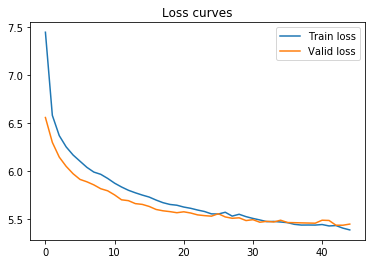

In [0]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))[:45]
plt.plot(epochs, [i[0] for i in plot_cache[:45]], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache[:45]], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

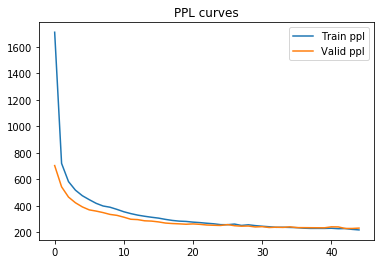

In [0]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))[:45]
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache[:45]], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache[:45]], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

### II.1 LSTM and Hyper-Parameters

#### 1. Define the dataset and dataloader

##### 1.1 Define the dataset

In [0]:
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [0]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = persona_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

##### 1.2 define the tokenized datasets

In [0]:
print(wiki_dataset['train'][1])

encoded = wiki_dict.encode_token_seq(wiki_dataset['train'][1])
print(wiki_dict.decode_idx_seq(encoded))

['Released', 'in', 'January', '2011', 'in', 'Japan', ',', 'it', 'is', 'the', 'third', 'game', 'in', 'the', 'Valkyria', 'series', '.']
['Released', 'in', 'January', '2011', 'in', 'Japan', ',', 'it', 'is', 'the', 'third', 'game', 'in', 'the', 'Valkyria', 'series', '.']


In [0]:
wiki_tokenized_datasets = tokenize_dataset(wiki_dataset, wiki_dict)
wiki_tensor_dataset = {}

for split, listoflists in wiki_tokenized_datasets.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wiki_tensor_dataset['train'][13]

100%|██████████| 9708/9708 [00:00<00:00, 131728.40it/s]


(tensor([[  0, 171,  70, 172, 173, 174, 175,  23, 176, 177, 111, 178, 179, 180,
           10, 111, 181, 182, 183, 173, 184, 185, 186,  30, 183, 173,   3, 187,
           39]]),
 tensor([[171,  70, 172, 173, 174, 175,  23, 176, 177, 111, 178, 179, 180,  10,
          111, 181, 182, 183, 173, 184, 185, 186,  30, 183, 173,   3, 187,  39,
            1]]))

##### Define the dataloader

In [0]:
wiki_loaders = {}

batch_size = 64

for split, wiki_dataset_tmp in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(wiki_dataset_tmp, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

#### 2. Define the model and initialize the model

##### 1. define the model


In [0]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.LSTM = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.LSTM(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [0]:
import os 

if not os.path.exists('/content/drive/My Drive/nlp2_save_model'):
  os.mkdir('/content/drive/My Drive/nlp2_save_model')

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import os

# creating a LSTM model, criterion and optimizer


# create the model folder
epoch_num = 0
load_pretrained = False


num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'
    
    
    

if load_pretrained:
    # input the epoch num you want to continue based on
    epoch_num = 0
    
    embedding_size = 256
    hidden_size = 512
    num_layers = 3
    rnn_dropout = 0.4

    model_predix = model_predix = '1002_LSTM_'+'dim_'+str(embedding_size)+'_hidden_size_'+str(hidden_size)+'rnn_dropout_'+str(rnn_dropout)+ '_num_layers_' +str(num_layers)
    path_root = '/content/drive/My Drive/nlp2_save_model/' + model_predix

    option_path = os.path.join(path_root,'options.pickle')
    f = open(option_path, 'rb')
    options = pickle.load(f)

  
    model_name = 'lstm' + str(epoch_num)+'.pth'
    model_path = os.path.join(path_root,model_name)
    if not os.path.exists(model_path):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load(model_path)
    model = LSTMLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict)
    
else:
  # setting the new model parametter
#     embedding_size = 256
#     hidden_size = 512
#     num_layers = 3
#     rnn_dropout = 0.3
    embedding_size = 256
    hidden_size = 512
    num_layers = 3
    rnn_dropout = 0.4
    
    model_predix = model_predix = '1002_LSTM_'+'dim_'+str(embedding_size)+'_hidden_size_'+str(hidden_size)+'_rnn_dropout_'+str(rnn_dropout)+ '_num_layers_' + str(num_layers)
    path_root = '/content/drive/My Drive/nlp2_save_model/' + model_predix

    if not os.path.exists(path_root):
      os.mkdir(path_root)
    
    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }
    
    model_para = options
    
    with open(os.path.join(path_root,'options.pickle'), 'wb') as handle:
      pickle.dump(model_para, handle, protocol=pickle.HIGHEST_PROTOCOL)

    model = LSTMLanguageModel(options).to(current_device)

    
criterion_train = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'),reduction = 'sum')
criterion_val = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'),reduction = 'sum')
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [0]:
model

LSTMLanguageModel(
  (lookup): Embedding(33181, 256, padding_idx=2)
  (LSTM): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.4)
  (projection): Linear(in_features=512, out_features=33181, bias=True)
)

In [0]:
# now we make same training loop, now with dataset and the model
import torch 
import pickle

model_para = options


# define the epoch number of start training

if load_pretrained == True:
  epoch_now = epoch_num +1
else:
  epoch_now = 0
  
# if using pretrained model, the load the previous plot_cache 
if load_pretrained:
  plot_cache = torch.load(os.path.join(path_root,'plot_acc'))
else:
  plot_cache = []
    
    
# start training

for epoch_number in range(epoch_now,100):
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_loss_cache = 0
        train_non_pad_tokens_cache = 0
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion_train(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            train_non_pad_tokens_cache += non_pad_tokens
            loss /= non_pad_tokens 
            
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                avg_loss = train_loss_cache/train_non_pad_tokens_cache
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                
    model_path = os.path.join(path_root,'lstm'+ str(epoch_number)+".pth")            
    torch.save(model.state_dict(), model_path)   
                         
           
            
    #do valid
    valid_loss_cache = 0
    valid_non_pad_tokens_cache = 0
    
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion_val(logits.view(-1, logits.size(-1)), target.view(-1))
            
            
            valid_loss_cache += loss.item()
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()  
            valid_non_pad_tokens_cache += non_pad_tokens  
              
        avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
        print(valid_non_pad_tokens_cache)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

#     if load_pretrained:
#         break
        
torch.save(plot_cache, os.path.join(path_root,'plot_acc'))  

In [0]:
torch.save(plot_cache, os.path.join(path_root,'plot_acc'))  

#### Load pretrained model and Evaluations 

In [0]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.LSTM = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.LSTM(embeddings)
        logits = self.projection(rnn_outputs[0])
        
    
        
        return logits

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import os

# creating a LSTM model, criterion and optimizer


# create the model folder
epoch_num = 0
load_pretrained = False


num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'
    
    
    
# input the epoch num you want for the evalutaion the epoch_num 36 seems to be the best model so far.
epoch_num = 36

embedding_size = 256
hidden_size = 512
num_layers = 3
rnn_dropout = 0.4

model_predix = model_predix = '1003_LSTM_'+'dim_'+str(embedding_size)+'_hidden_size_'+str(hidden_size)+'_rnn_dropout_'+str(rnn_dropout)+ '_num_layers_' +str(num_layers)
path_root = '/content/drive/My Drive/nlp2_save_model/' + model_predix

option_path = os.path.join(path_root,'options.pickle')
f = open(option_path, 'rb')
options = pickle.load(f)


model_name = 'lstm' + str(epoch_num)+'.pth'
model_path = os.path.join(path_root,model_name)
if not os.path.exists(model_path):
    raise EOFError('Download pretrained model!')
model_dict = torch.load(model_path)
model = LSTMLanguageModel(options).to(current_device)
model.load_state_dict(model_dict)
    

    
criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'),reduction = 'sum')

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [0]:
valid_loss_cache = 0
valid_non_pad_tokens_cache = 0
model.eval()
epoch_number = 36
with torch.no_grad():
    for i, (inp, target) in enumerate(wiki_loaders['valid']):
        inp = inp.to(current_device)
        target = target.to(current_device)
        logits = model(inp)

        loss = criterion_val(logits.view(-1, logits.size(-1)), target.view(-1))


        valid_loss_cache += loss.item()
        non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()  
        valid_non_pad_tokens_cache += non_pad_tokens  

    avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
    print(valid_non_pad_tokens_cache)
    print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        

#### Results (LSTM vs. Baseline)

In [0]:
plot_cache = torch.load(os.path.join(path_root,'plot_acc'))

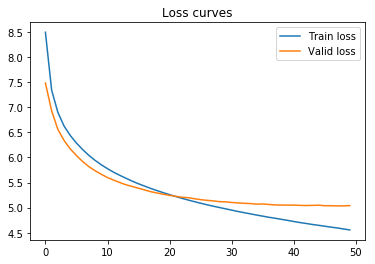

In [0]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

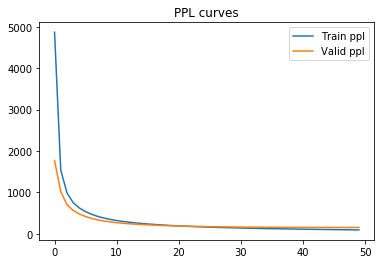

In [0]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

In [0]:
loss_list = []
for i in plot_cache:
  loss_list.append(i[1])
  
print(min(loss_list))
print(2**(min(loss_list)/numpy.log(2)))

5.034621244505723
153.64138906982416


#### Performance Variation Based on Hyperparameter Values

In [0]:
#Load and Prepare Data
date = ['1003','1002','1002',
        '1003','1002','1003']
base_date = '1002'
#epoch_num = 36
embedding_size = 256
base_embedding_size = 256
hidden_size = [128, 300, 512, 
               800, 512, 512]
base_hidden_size = 512
num_layers = 3
rnn_dropout = [0.3, 0.3, 0.3, 
               0.3, 0.2, 0.4]
base_dropout = 0.3
               
best_perplexity_list = []
hyperparameter_list = []
epoch_list = []
for h in range(len(date)+1):
  if h == len(date):
    model_predix = base_date+'_RNN_'+'dim_'+str(base_embedding_size)+'_hidden_size_'+str(base_hidden_size)+'_rnn_dropout_'+str(base_dropout)+ '_num_layers_' +str(num_layers)
    hyperparameter = 'RNN_HiddenSize'+str(base_hidden_size)+'Dropout'+str(base_dropout) 
  else:
    hyperparameter = 'HiddenSize'+str(hidden_size[h])+'Dropout'+str(rnn_dropout[h])
    model_predix = date[h]+'_LSTM_'+'dim_'+str(embedding_size)+'_hidden_size_'+str(hidden_size[h])+'_rnn_dropout_'+str(rnn_dropout[h])+ '_num_layers_' +str(num_layers)
  
  hyperparameter_list.append(hyperparameter)
  path_root = '/content/drive/My Drive/nlp2_save_model/' + model_predix
  
  option_path = os.path.join(path_root,'options.pickle')
  f = open(option_path, 'rb')
  options = pickle.load(f)
  
  plot_cache = torch.load(os.path.join(path_root,'plot_acc'))
  loss_list = []
  for i in plot_cache:
    loss_list.append(i[1])
  epoch_list.append(loss_list.index(min(loss_list)))
  best_perplexity = 2**(min(loss_list)/numpy.log(2))
  best_perplexity_list.append(best_perplexity)
    

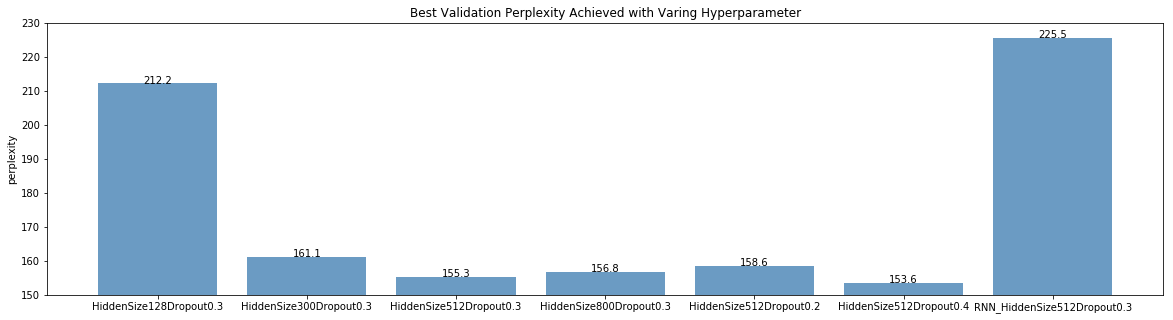

In [0]:
#best_perplexity_list = np.array([153, 152, 154])
#hyperparameter_list = ['hidden 300','hidden 512','hidden 800']
plt.figure(figsize=(20,5))

plt.bar(range(len(best_perplexity_list)),best_perplexity_list,align = "center",color = "steelblue",alpha = 0.8)

plt.ylabel("perplexity")

plt.ylim([150,230])

plt.xticks(range(len(best_perplexity_list)),hyperparameter_list)

plt.title('Best Validation Perplexity Achieved with Varing Hyperparameter')

for x,y in enumerate(best_perplexity_list):
    plt.text(x,y,'%s' %round(y,1),ha='center')

plt.show()   

Overall our LSTM model is obviously better than the baseline RNN model. It's hard for RNN to store long term information effectively, while for LSTM the memory cells help to conduct information better during backpropogation through time, and therefore reduce perplexity robustly. 

The results differ when hyperparameter varing. For given dropout rate 0.3, perplexity descends along with the increase of hidden dimension. That is because the ability of small hidden dimension to capturing effective information is not enough. And for given hidden size 512, perplexity is not signicantly sensitive to dropout rate, though it goes down slightly when dropout rate increases from 0.2 to 0.4.

In [0]:
# input the epoch num you want for the evalutaion the epoch_num 36 seems to be the best model so far.
epoch_num = 36

embedding_size = 256
hidden_size = 512
num_layers = 3
rnn_dropout = 0.3

model_predix = model_predix = '1002_LSTM_'+'dim_'+str(embedding_size)+'_hidden_size_'+str(hidden_size)+'_rnn_dropout_'+str(rnn_dropout)+ '_num_layers_' +str(num_layers)
path_root = '/content/drive/My Drive/nlp2_save_model/' + model_predix

option_path = os.path.join(path_root,'options.pickle')
f = open(option_path, 'rb')
options = pickle.load(f)


model_name = 'lstm' + str(epoch_num)+'.pth'
model_path = os.path.join(path_root,model_name)

print(model_path)

In [0]:
print(epoch_list)

[49, 49, 40, 30, 37, 47, 65]


In [0]:
# the md5
!md5sum '/content/drive/My Drive/nlp2_save_model/1003_LSTM_dim_256_hidden_size_128_rnn_dropout_0.3_num_layers_3/lstm49.pth'
!md5sum '/content/drive/My Drive/nlp2_save_model/1002_LSTM_dim_256_hidden_size_300_rnn_dropout_0.3_num_layers_3/lstm49.pth'
!md5sum '/content/drive/My Drive/nlp2_save_model/1002_LSTM_dim_256_hidden_size_512_rnn_dropout_0.3_num_layers_3/lstm40.pth'
!md5sum '/content/drive/My Drive/nlp2_save_model/1003_LSTM_dim_256_hidden_size_800_rnn_dropout_0.3_num_layers_3/lstm30.pth'
!md5sum '/content/drive/My Drive/nlp2_save_model/1002_LSTM_dim_256_hidden_size_512_rnn_dropout_0.2_num_layers_3/lstm37.pth'
!md5sum '/content/drive/My Drive/nlp2_save_model/1003_LSTM_dim_256_hidden_size_512_rnn_dropout_0.4_num_layers_3/lstm47.pth'
!md5sum '/content/drive/My Drive/nlp2_save_model/1002_RNN_dim_256_hidden_size_512_rnn_dropout_0.3_num_layers_3/lstm65.pth'

0922cfc91baaea939edd33935f4b3c28  /content/drive/My Drive/nlp2_save_model/1003_LSTM_dim_256_hidden_size_128_rnn_dropout_0.3_num_layers_3/lstm49.pth
ebeabbea43d6744fc53bb6fa6fb12934  /content/drive/My Drive/nlp2_save_model/1002_LSTM_dim_256_hidden_size_300_rnn_dropout_0.3_num_layers_3/lstm49.pth
c9917991758512721595f732d1809663  /content/drive/My Drive/nlp2_save_model/1002_LSTM_dim_256_hidden_size_512_rnn_dropout_0.3_num_layers_3/lstm40.pth
eaea260f12c69b4dc7db938b0ccc5143  /content/drive/My Drive/nlp2_save_model/1003_LSTM_dim_256_hidden_size_800_rnn_dropout_0.3_num_layers_3/lstm30.pth
92389914c77065c7655ac0765e017506  /content/drive/My Drive/nlp2_save_model/1002_LSTM_dim_256_hidden_size_512_rnn_dropout_0.2_num_layers_3/lstm37.pth
fe7078bba792df34677c1d37eee21154  /content/drive/My Drive/nlp2_save_model/1003_LSTM_dim_256_hidden_size_512_rnn_dropout_0.4_num_layers_3/lstm47.pth
5cd22f5cdc78d0b49911e9a5689664b3  /content/drive/My Drive/nlp2_save_model/1002_RNN_dim_256_hidden_size_512_rnn_d

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [0]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(15,15))
    
    c_list = ['r','orange','lime','purple','k']

    for v in range(5):
      to_plot = reduced[word_ids[v*10:(v+1)*10], :]
      plt.scatter(to_plot[:, 0], to_plot[:, 1], c = c_list[v], marker = 'x')
      for i, word_id in enumerate(word_ids[v*10:(v+1)*10]):
        current_point = to_plot[i]
        plt.annotate(words[i+v*10], (current_point[0], current_point[1]))
        

      to_plot = reduced[word_ids[v*10+50:(v+1)*10+50], :]
      plt.scatter(to_plot[:, 0], to_plot[:, 1], c = c_list[v])
      for i, word_id in enumerate(word_ids[v*10+50:(v+1)*10+50]):
        current_point = to_plot[i]
        plt.annotate(words[i+v*10+50], (current_point[0], current_point[1]))
        
  
    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dist', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


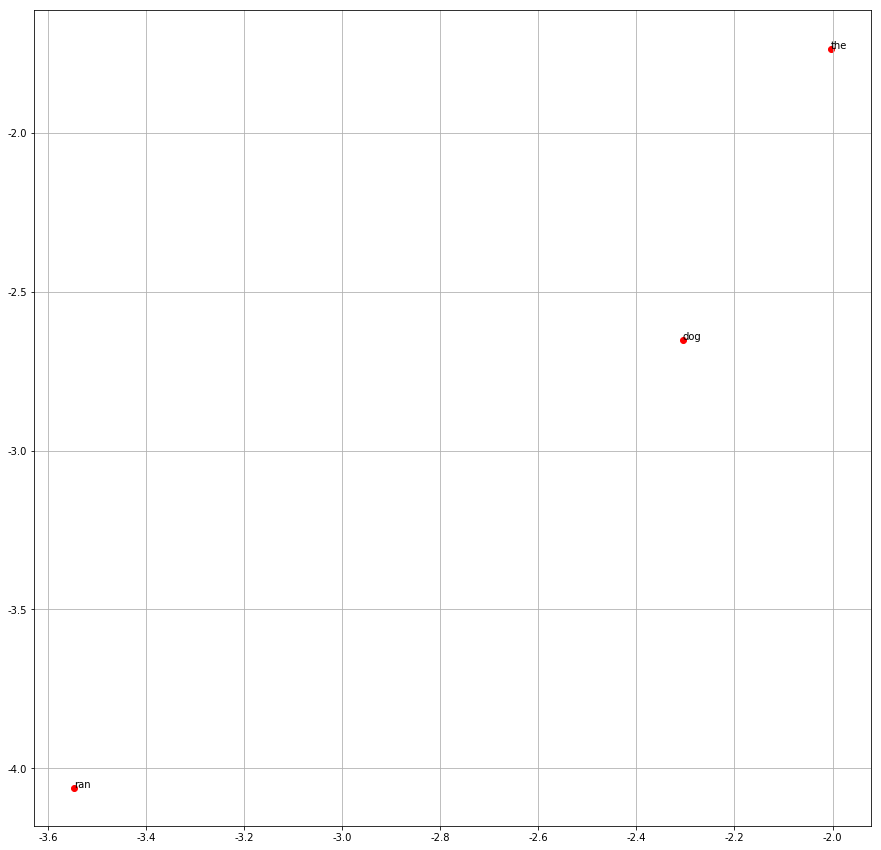

In [0]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### II.2.1 Word Similarity

In [0]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.LSTM = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.LSTM(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import os

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:  
    current_device = 'cpu'

path_root = '/content/drive/My Drive/nlp2_save_model/1003_LSTM_dim_256_hidden_size_512_rnn_dropout_0.4_num_layers_3'

option_path = os.path.join(path_root, 'options.pickle')
f = open(option_path, 'rb')
options = pickle.load(f)

model_name = 'lstm' + str(47)+'.pth'
model_path = os.path.join(path_root, model_name)
if not os.path.exists(model_path):
    raise EOFError('Download pretrained model!')
model_dict = torch.load(model_path)
model = LSTMLanguageModel(options).to(current_device)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [0]:
embeds = model.lookup
current_device = 'cuda'

words=['the', 'run', 'dog', 'where', 'quick']

out_v1=[]
for i in words:
  lookup_tensor = torch.tensor(wiki_dict.encode_token_seq([i]), dtype=torch.long)
  lookup_tensor = lookup_tensor.to(current_device)
  out_embed = embeds(lookup_tensor)
  out_v1.append(out_embed)

  
out_v2 = []
for i in wiki_dict.tokens:
  lookup_tensor = torch.tensor(wiki_dict.encode_token_seq([i]), dtype=torch.long)
  lookup_tensor = lookup_tensor.to(current_device)
  out_embed = embeds(lookup_tensor)
  out_v2.append(out_embed)

In [0]:
from scipy import spatial
def cosine_distance(v1, v2):
  v1, v2 = v1.data.cpu().numpy(), v2.data.cpu().numpy()
  return  1 - spatial.distance.cosine(v1, v2)

In [0]:
furthest_50, closest_50 = [], []
furthest_50_index, closest_50_index = [], []
for i in out_v1:
  dist = []
  for j in out_v2:
    dist.append(torch.nn.functional.cosine_similarity(i, j, dim=1, eps=1e-8))
  print('-----------------------------------------------------------------------------------------------------------------------')
  furthest_10_index = sorted(range(len(dist)), key = lambda i: dist[i])[:10]
  #print(furthest_10_index)
  print('furtherest:', [wiki_dict.tokens[i] for i in furthest_10_index])
  closest_10_index = sorted(range(len(dist)), key = lambda i: dist[i])[-11:-1] # first index should be index of the word itself
  #print(closest_10_index)
  print('closest:', [wiki_dict.tokens[i] for i in closest_10_index])
  furthest_50.extend([wiki_dict.tokens[i] for i in furthest_10_index])
  closest_50.extend([wiki_dict.tokens[i] for i in closest_10_index])
  furthest_50_index.extend(furthest_10_index)
  closest_50_index.extend(closest_10_index)
  
words_100 = furthest_50 + closest_50
words_100_index = furthest_50_index + closest_50_index

-----------------------------------------------------------------------------------------------------------------------
furtherest: ['perennial', 'Puerto', 'vice', 'ligand', 'target', 'similar', 'counterparts', 'Medal', 'sir', 'funk']
closest: ['Robbie', 'Branagh', 'Royal', 'live', 'perceives', '199', 'Toro', 'Barremian', 'revisited', 'under']
-----------------------------------------------------------------------------------------------------------------------
furtherest: ['legitimacy', 'Dunvegan', 'Halley', 'Aniston', 'sanctuaries', 'bombardment', '129', 'scope', 'cabled', 'Panthers']
closest: ['bullied', 'digestive', 'Read', 'Boulevard', '136', 'Europium', 'Weinstein', 'Bielen', 'fan', 'Wawrinka']
-----------------------------------------------------------------------------------------------------------------------
furtherest: ['Ratzenberger', 'Prohibition', 'surprised', 'Continuing', 'presenters', 'NMDA', 'Months', 'interrupted', 'infatuation', 'diplomat']
closest: ['underneath', '

#### II.2.2 Embedding Layer

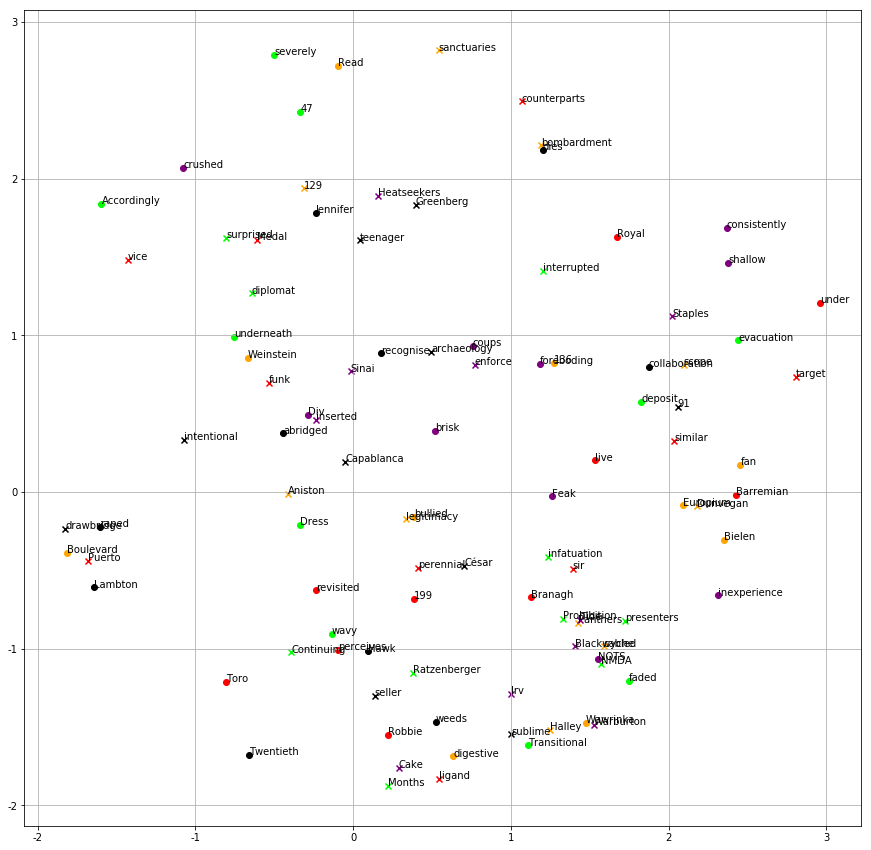

In [0]:
umap_plot(model.lookup.weight, words_100_index, words_100)

#### II.2.3 Projection Layer

In [0]:
projection_embedding = model.state_dict()['projection.weight']
current_device = 'cuda'
    
words=['the', 'run', 'dog', 'where', 'quick']

out_v1=[]
for i in words:
  projection_ID = wiki_dict.get_id(i)
  v1_embed = projection_embedding[projection_ID].unsqueeze_(0).to(current_device)
  out_v1.append(v1_embed)

  
out_v2 = []
for i in range(len(wiki_dict)):
  v2_embed = projection_embedding[i, :].unsqueeze_(0).to(current_device)
  out_v2.append(v2_embed)
  

In [0]:
furthest_50, closest_50 = [], []
furthest_50_index, closest_50_index = [], []
for i in out_v1:
  dist = []
  for j in out_v2:
    dist.append(torch.nn.functional.cosine_similarity(i, j, dim = 1, eps = 1e-8))
  print('------------------------------------------------------------------------------------------------------------------------')
  furthest_10_index = sorted(range(len(dist)), key = lambda i: dist[i])[:10]
  closest_10_index = sorted(range(len(dist)), key = lambda i: dist[i])[-11:-1] # first index should be index of the word itself
  furthest_50.extend([wiki_dict.tokens[i] for i in furthest_10_index])
  print('furtherest:', [wiki_dict.tokens[i] for i in furthest_10_index])
  #print(furthest_10_index)
  closest_50.extend([wiki_dict.tokens[i] for i in closest_10_index])
  print('closest:', [wiki_dict.tokens[i] for i in closest_10_index])
  #print(closest_10_index)
  furthest_50_index.extend(furthest_10_index)
  closest_50_index.extend(closest_10_index)
  
words_100 = furthest_50 + closest_50
words_100_index = furthest_50_index + closest_50_index

------------------------------------------------------------------------------------------------------------------------
furtherest: ['–', ';', '@.@', 'or', '<', 'also', 'had', 'but', 'are', 'A']
closest: ['assuring', 'Battleship', 'Amtrak', 'Pulteney', 'Sichuan', 'donning', 'ranchers', 'a', 'expedite', 'Graphics']
------------------------------------------------------------------------------------------------------------------------
furtherest: ['Bracknell', 'fragilis', 'hygrometricus', 'asiaticus', 'laevigatum', 'chailletii', 'Peulan', 'bernissartensis', 'areolatum', 'Jaye']
closest: ['strike', 'block', 'shoot', 'approach', 'move', 'play', 'pass', 'win', 'campaign', 'drive']
------------------------------------------------------------------------------------------------------------------------
furtherest: ['Honduras', 'Puerto', 'Greece', '1902', '1886', 'Perth', 'Lycoming', 'Turkey', 'Maine', '1885']
closest: ['goat', 'girl', 'fox', 'portrait', 'doctor', 'gang', 'mother', 'hero', 'bo

The closest and furtherest words we select for each word in "'the', 'run', 'dog', 'where', 'quick'" are indeed 'similar' or 'opposed' to the word in some aspects. For instance, as 'run' is a verb, its closest words are all verbs, while the closest words to 'dog' are all nouns. And the furthest words to each word have no relationship with the word neither in the part of speech nor in the literary meaning. 

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


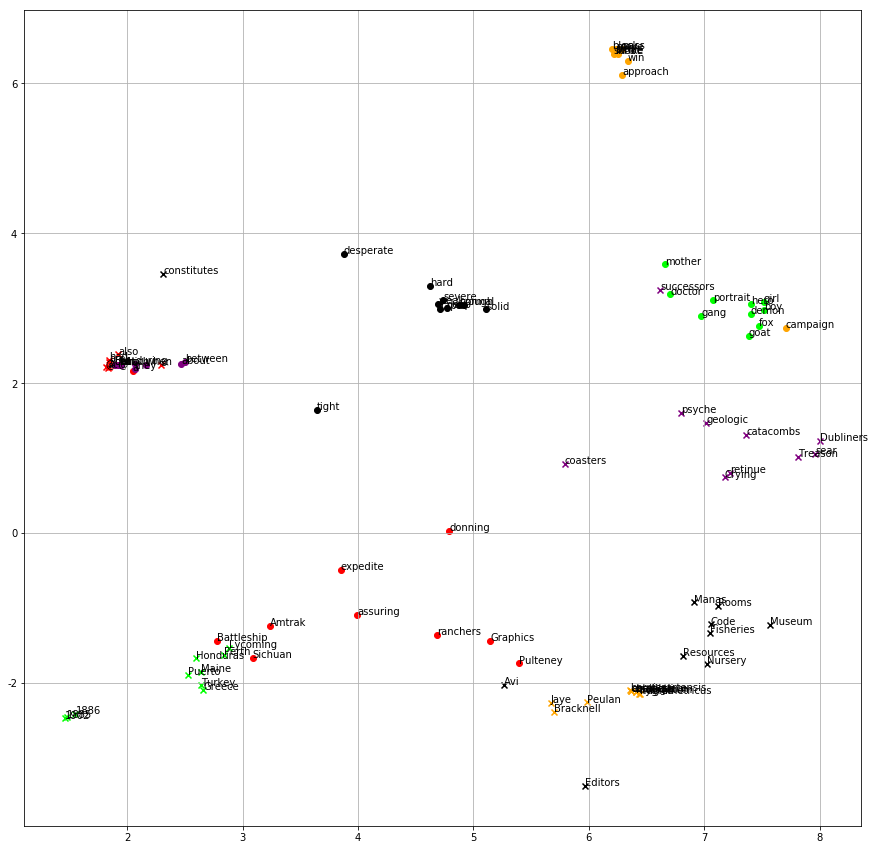

In [0]:
umap_plot(model.projection.weight, words_100_index, words_100)

The plot shows that for each words in "'the', 'run', 'dog', 'where', 'quick'", the 'closest' words cluster on our map, while the 'furtherest' words distributed far away from the 'closet' ones. Therefore, the distance between two words on this map reflects their similarity effectively.

There is significant difference between plot of embedding layer and that of projection layer. After projected, the words embedding is meaningful in measuring similarity.

### II.3 Scoring

In [0]:
# load model
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import os

# creating a LSTM model, criterion and optimizer


# create the model folder
epoch_num = 0
load_pretrained = False


num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'
    
    
    
# input the epoch num you want for the evalutaion the epoch_num 36 seems to be the best model so far.
epoch_num = 36

embedding_size = 256
hidden_size = 512
num_layers = 3
rnn_dropout = 0.3

model_predix = model_predix = '1002_LSTM_'+'dim_'+str(embedding_size)+'_hidden_size_'+str(hidden_size)+'_rnn_dropout_'+str(rnn_dropout)+ '_num_layers_' +str(num_layers)
path_root = '/content/drive/My Drive/nlp2_save_model/' + model_predix

option_path = os.path.join(path_root,'options.pickle')
f = open(option_path, 'rb')
options = pickle.load(f)


model_name = 'lstm' + str(epoch_num)+'.pth'
model_path = os.path.join(path_root,model_name)
if not os.path.exists(model_path):
    raise EOFError('Download pretrained model!')
model_dict = torch.load(model_path)
model = LSTMLanguageModel(options).to(current_device)
model.load_state_dict(model_dict)
    

    
criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'),reduction = 'sum')

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [0]:
import torch
import math

def Scoring_each_word(model,previous_words, new_word, previous_score):
#     print(previous_words)
#     print(new_word)
    previous_words = previous_words.to(current_device)
    logits = model(previous_words) 
    probs = torch.nn.functional.softmax(logits[:,-1,:],dim=1)
    weight = probs.detach().cpu().numpy()[0,:]
    
    score_tmpt = math.log2(weight[new_word])
#     print(weight[new_word])
    
    new_score = previous_score + score_tmpt
    return new_score
  
def Scoring_the_sentence(model,sentence):
    # sentence 1,sentence_len
    sentence_len = len(sentence)
    score = 0
    for ind in range(1,sentence_len):
      previous_words=torch.tensor([sentence[:ind]])
      new_word = torch.tensor([[sentence[ind]]])
      score = Scoring_each_word(model,previous_words, new_word, score)
    return score


In [0]:
# an example

sentence = [0, 75, 1415, 2528, 3138, 5395, 23, 6878, 85, 8, 1697, 10, 2150, 20, 650, 5, 13707, 1675, 2049, 6267, 30, 2049, 6366, 61, 6, 319, 5, 23459, 3472, 421, 588, 358, 1531, 6, 2728, 11069, 39, 1]


score1 = Scoring_the_sentence(model,sentence)

In [0]:
# get the scoring list
score_list = []
len_val = len(wiki_tokenized_datasets['valid'])
for idx, sen in enumerate(wiki_tokenized_datasets['valid']):
  score_list.append(Scoring_the_sentence(model,sen))

In [0]:
# save the score list
score_list_path = os.path.join(path_root,'score_list.pickle')
with open(score_list_path, 'wb') as handle:
  pickle.dump(score_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

load the saved files

In [0]:
# read the socre list 
score_list_path = os.path.join(path_root,'score_list.pickle')
f2 = open(score_list_path, 'rb')
score_list_loaded = pickle.load(f2)

In [0]:
print(score_list_loaded)

[-233.55874624504204, -85.51006934214688, -176.18992485088867, -146.92541801345791, -181.07374758492668, -198.11691725438777, -162.57362052390758, -258.5163954194448, -37.45832775625083, -174.1059646629885, -180.89230702011926, -101.43049246502237, -98.72099437427526, -181.99371272280496, -109.23525845218958, -104.71651333179484, -101.90902293184952, -247.541182383032, -124.85772238678692, -208.12456257150123, -67.31572664504921, -163.68246543621814, -209.2701525122888, -222.37062448557523, -195.07769750852202, -106.71379176306381, -207.20344221579143, -127.91526409754907, -105.43984305128325, -204.89573511179432, -162.68170934673773, -166.58115990066386, -123.12639492134512, -194.50812303665555, -188.7421755846456, -191.67012821048792, -113.35511993941353, -284.249690217851, -160.96755314610627, -92.59270667415886, -196.05008914869168, -206.9559865941314, -166.76898148824912, -134.14291035013918, -104.49094509343804, -208.54520178716322, -101.39030272971277, -130.24548448636781, -85.6

#### II.3.2 Highest and Lowest scoring sequences

In [0]:
import heapq

max_score_index_list_tempt = map(score_list_loaded.index, heapq.nlargest(10, score_list_loaded))


min_score_index_list_tempt = map(score_list_loaded.index, heapq.nsmallest(10, score_list_loaded))


max_score_index_list = []
for i_high in max_score_index_list_tempt:
  max_score_index_list.append(i_high)
  
  
min_score_index_list = []
for i_min in min_score_index_list_tempt:
  min_score_index_list.append(i_min)  
  

In [0]:
for i_high in max_score_index_list:
  print(i_high)

129
6750
6464
3723
4284
8050
2261
7143
4403
8


In [0]:
# read the socre list 
f2 = open(score_list_path, 'rb')
score_list_loaded = pickle.load(f2)
print(score_list_loaded)

[-233.55874624504204, -85.51006934214688, -176.18992485088867, -146.92541801345791, -181.07374758492668, -198.11691725438777, -162.57362052390758, -258.5163954194448, -37.45832775625083, -174.1059646629885, -180.89230702011926, -101.43049246502237, -98.72099437427526, -181.99371272280496, -109.23525845218958, -104.71651333179484, -101.90902293184952, -247.541182383032, -124.85772238678692, -208.12456257150123, -67.31572664504921, -163.68246543621814, -209.2701525122888, -222.37062448557523, -195.07769750852202, -106.71379176306381, -207.20344221579143, -127.91526409754907, -105.43984305128325, -204.89573511179432, -162.68170934673773, -166.58115990066386, -123.12639492134512, -194.50812303665555, -188.7421755846456, -191.67012821048792, -113.35511993941353, -284.249690217851, -160.96755314610627, -92.59270667415886, -196.05008914869168, -206.9559865941314, -166.76898148824912, -134.14291035013918, -104.49094509343804, -208.54520178716322, -101.39030272971277, -130.24548448636781, -85.6

In [0]:
for i_high in max_score_index_list:
  print(score_list_loaded[i_high])

-21.302560607956586
-23.929534004378628
-24.591417630263052
-32.896550006061865
-33.814204826280644
-34.09058488337913
-35.306269354307844
-36.49247944086449
-36.63208179939434
-37.45832775625083


In [0]:
for i_high in min_score_index_list:
  print(score_list_loaded[i_high])

-806.5592168956654
-756.3952668563455
-750.2266625052922
-689.461122266622
-661.305791230575
-651.1399061726656
-649.9484001767318
-647.2934510775613
-644.5530909879491
-639.0541621564104


In [0]:
# reporting the 10 highest scoring sequences
for i_high in max_score_index_list:
  print(wiki_dict.decode_idx_seq(wiki_tokenized_datasets['valid'][i_high]))

['<bos>', '=', '=', 'Post', '@-@', 'war', 'career', '=', '=', '<eos>']
['<bos>', '=', '=', 'Early', 'life', 'and', 'education', '=', '=', '<eos>']
['<bos>', '=', '=', 'Post', '@-@', 'war', 'period', '=', '=', '<eos>']
['<bos>', '=', '=', '=', 'Scientology', 'sources', '=', '=', '=', '<eos>']
['<bos>', '=', '=', 'Return', 'to', 'New', 'Zealand', '=', '=', '<eos>']
['<bos>', '=', '=', '=', 'Hit', 'list', '=', '=', '=', '<eos>']
['<bos>', '=', '=', '=', 'Raid', 'of', '<unk>', '=', '=', '=', '<eos>']
['<bos>', '=', '=', '=', 'Army', 'returns', '=', '=', '=', '<eos>']
['<bos>', '=', '=', '=', '<unk>', 'from', 'the', 'stage', '=', '=', '=', '<eos>']
['<bos>', '1', '@.@', '5', '–', '4', '@.@', '9', 'lb', ')', '.', '<eos>']


In [0]:
# reporting the 10 lowest scoring sequences
for i_low in min_score_index_list:
  print(wiki_dict.decode_idx_seq(wiki_tokenized_datasets['valid'][i_low]))

['<bos>', 'To', 'further', 'justify', 'its', 'stance', ',', 'the', 'German', 'government', 'has', 'also', 'pointed', 'to', 'the', 'long', 'history', 'of', 'U.S.', 'court', 'cases', 'involving', 'Scientology', ',', 'including', 'the', 'conviction', 'of', '11', 'top', 'Scientologists', 'in', '1979', 'and', '1980', 'for', 'a', 'conspiracy', 'involving', 'the', 'infiltration', 'of', 'U.S.', 'government', 'agencies', ',', '<unk>', 'and', 'the', 'theft', 'of', 'government', 'documents', ',', 'a', '1994', 'U.S.', 'Supreme', 'Court', 'finding', 'that', 'Scientology', 'practices', 'took', 'place', 'in', 'a', '"', '<unk>', 'environment', '"', ',', 'and', 'Scientology', "'s", 'track', 'record', 'of', 'pursuing', 'its', 'critics', 'through', 'malicious', 'court', 'cases', 'and', 'private', 'investigators', '.', '<eos>']
['<bos>', 'The', 'letter', 'was', 'conceived', 'and', 'paid', 'for', 'by', 'Hollywood', 'lawyer', '<unk>', 'Fields', ',', 'whose', 'clients', 'have', 'included', 'Tom', 'Cruise', '

#### II.3.3 Modified sequences

In [0]:
import torch
import math

def Scoring_each_word(model,previous_words, new_word, previous_score):
#     print(previous_words)
    print(new_word)
    previous_words = previous_words.to(current_device)
    logits = model(previous_words) 
    probs = torch.nn.functional.softmax(logits[:,-1,:],dim=1)
    weight = probs.detach().cpu().numpy()[0,:]
    
    score_tmpt = math.log2(weight[new_word])
    print(weight[new_word])
    
    new_score = previous_score + score_tmpt
    return new_score
  
def Scoring_the_sentence(model,sentence):
    # sentence 1,sentence_len
    sentence_len = len(sentence)
    score = 0
    for ind in range(1,sentence_len):
      previous_words=torch.tensor([sentence[:ind]])
      new_word = torch.tensor([[sentence[ind]]])
      score = Scoring_each_word(model,previous_words, new_word, score)
    return score


In [0]:
# reporting the second highest scoring sequences
print(max_score_index_list[1])
select_seq = max_score_index_list[1]
print(Scoring_the_sentence(model,wiki_tokenized_datasets['valid'][select_seq]))

print(wiki_tokenized_datasets['valid'][select_seq])
print(wiki_dict.decode_idx_seq(wiki_tokenized_datasets['valid'][select_seq]))

6750
tensor([[1907]])
0.00843767
tensor([[1907]])
0.8951118
tensor([[1908]])
0.012344734
tensor([[1081]])
0.15527904
tensor([[30]])
0.38670206
tensor([[1834]])
0.0045189
tensor([[1907]])
0.804139
tensor([[1907]])
0.96535236
tensor([[1]])
0.88556737
-25.777025245826373
[0, 1907, 1907, 1908, 1081, 30, 1834, 1907, 1907, 1]
['<bos>', '=', '=', 'Early', 'life', 'and', 'education', '=', '=', '<eos>']


In [0]:
# the case when the score becomes lower. change the second character 1907 to 1908

seq_report_ori = [0, 1907, 1907, 1908, 1081, 30, 1834, 1907, 1907, 1]

seq_report_modified = [0, 1908, 1907, 1908, 1081, 30, 1834, 1907, 1907, 1]

print(Scoring_the_sentence(model,seq_report_modified))

print(wiki_dict.decode_idx_seq(seq_report_modified))


tensor([[1908]])
0.0008039524
tensor([[1907]])
5.9606236e-07
tensor([[1908]])
0.00013592021
tensor([[1081]])
0.00069445727
tensor([[30]])
0.44164297
tensor([[1834]])
0.0010586794
tensor([[1907]])
0.044593282
tensor([[1907]])
0.9628163
tensor([[1]])
0.913328
-70.0304729063182
['<bos>', 'Early', '=', 'Early', 'life', 'and', 'education', '=', '=', '<eos>']


The reason that it becomes lo: changing the '=' to "early" decrease the probability in the first place, since it is more unlikely that a sentence begin with early than '='. P(=|Early) is also lower than P(=|=). As a result, the total probability decreases.

In [0]:
# the case when the score becomes higher. change the second character 1907 to 1908

seq_report_ori = [0, 1907, 1907, 1908, 1081, 30, 1834, 1907, 1907, 1]

seq_report_modified = [0, 1907, 1907, 1908, 1081, 1907, 1907, 1907, 1907, 1]

print(Scoring_the_sentence(model,seq_report_modified))

print(wiki_dict.decode_idx_seq(seq_report_modified))

tensor([[1907]])
0.010111074
tensor([[1907]])
0.8429221
tensor([[1908]])
0.022185775
tensor([[1081]])
0.053017244
tensor([[1907]])
0.22220425
tensor([[1907]])
0.96603304
tensor([[1907]])
0.9830651
tensor([[1907]])
0.027293608
tensor([[1]])
0.9943493
-24.05407130541059
['<bos>', '=', '=', 'Early', 'life', '=', '=', '=', '=', '<eos>']


Slightly higher than the original case, since the probability of p(=|=) is higher than P(=|education)

### II.4 Sampling

##### 1. Sampling Function

In [0]:
import torch
def sampling(model,previous_words):
    previous_words = previous_words.to(current_device)
    logits = model(previous_words) 
    probs = torch.nn.functional.softmax(logits[:,-1,:],dim=1)
    weight = probs.detach().cpu().numpy()[0,:]
    sample = torch.multinomial(torch.tensor(weight), 1, replacement=True)
    return sample

##### 2. Conduct sampling

In [0]:
sentence_list = []
num_sampling = 1000

for i in range(num_sampling):
  previous_words = torch.tensor([[0]])
  
  
  sample_tmp = sampling(model,previous_words)
#   print(sample_tmp.unsqueeze(0))
#   print(previous_words)

  # to align the shape so that they match
  word_now = sample_tmp.unsqueeze(0)
  
  # to combine the word 
  previous_words = torch.cat((previous_words,word_now), dim=1)
  while sample_tmp.numpy()[0]!= 1:
    sample_tmp = sampling(model,previous_words)
#     print(sample_tmp)
    word_now = sample_tmp.unsqueeze(0)
    previous_words = torch.cat((previous_words,word_now), dim=1)
#   print(previous_words.numpy())
  sentence_list.append(previous_words.numpy()[0,:])
    


In [0]:
# save the sampling sentence
sampling_sentence_path = os.path.join(path_root,'samping_sentences_by_model.pickle')
with open(sampling_sentence_path, 'wb') as handle:
  pickle.dump(sentence_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# load the sampling sentence
sampling_sentence_path = os.path.join(path_root,'samping_sentences_by_model.pickle')
f = open(sampling_sentence_path, 'rb')
sampling_sentence_list = pickle.load(f)

In [0]:
# double check

print(len(sampling_sentence_list))

1000


#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

##### 1. Select the 1000 randomly validation-set sequences

In [0]:
import random

model_predix = model_predix = '1002_LSTM_'+'dim_'+str(embedding_size)+'_hidden_size_'+str(hidden_size)+'_rnn_dropout_'+str(rnn_dropout)+ '_num_layers_' + str(num_layers)
path_root = '/content/drive/My Drive/nlp2_save_model/' + model_predix

random_val_sentence_list = []

random_index_list = random.sample(range(len(wiki_tokenized_datasets['valid'])),1000)
print(random_index_list)
                                  
for idx in random_index_list:
    random_val_sentence_list.append(wiki_tokenized_datasets['valid'][idx])      
                                  
random_val_sentence_path = os.path.join(path_root,'random_val_sentences.pickle')

[4302, 6006, 5176, 583, 7342, 2180, 5913, 8451, 1617, 2359, 5080, 7541, 104, 2104, 5488, 5365, 3219, 5666, 405, 4628, 1063, 4370, 1054, 182, 4597, 6933, 3621, 7981, 7208, 6947, 3655, 5663, 7780, 5141, 827, 5207, 7676, 681, 2148, 5232, 4250, 5034, 3221, 526, 6878, 4324, 1971, 3783, 1393, 3867, 2670, 6812, 7318, 1294, 425, 1933, 8364, 5304, 5565, 5801, 7902, 2942, 6661, 5799, 5920, 585, 7136, 7497, 2524, 7201, 5641, 2301, 4756, 10, 782, 4236, 6734, 5424, 6077, 3505, 1799, 7722, 288, 862, 829, 8276, 1276, 6084, 4939, 7939, 6065, 6072, 466, 5564, 3146, 98, 4144, 3818, 771, 1193, 2342, 5841, 5596, 6921, 4310, 3761, 4196, 3643, 7416, 4676, 1093, 4585, 6935, 7211, 8275, 2518, 2114, 3350, 7140, 4257, 6066, 1032, 2127, 4265, 6061, 6769, 1331, 5940, 6118, 8370, 3109, 7913, 2828, 6232, 5405, 218, 4243, 8442, 5394, 1970, 4815, 5715, 5775, 5324, 5863, 3079, 7718, 2117, 3424, 3807, 2260, 67, 7724, 5180, 2566, 5524, 6631, 7134, 500, 2339, 8014, 655, 3617, 834, 2036, 276, 5455, 6783, 4132, 285, 7821, 

In [0]:
# save the sampling from the validation 
random_val_sentence_path = os.path.join(path_root,'random_val_sentences.pickle')
with open(random_val_sentence_path, 'wb') as handle:
  pickle.dump(random_val_sentence_list, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [0]:
random_val_sentence_path = os.path.join(path_root,'random_val_sentences.pickle')
f1 = open(random_val_sentence_path, 'rb')
random_val_sentence_list = pickle.load(f1)

In [0]:
# double check
print(random_val_sentence_list[0])
print(len(random_val_sentence_list))

[0, 75, 668, 8047, 85, 4261, 1331, 118, 20, 2664, 2250, 5, 598, 741, 1618, 5, 3072, 30, 5274, 287, 406, 4226, 1]
1000


##### 2. Compare The Results

In [0]:

import numpy as np
import matplotlib.pyplot as plt

def get_statistics(sampling_sentence_list):
  # do some statistics about the sampled token
  import numpy as np
  import matplotlib.pyplot as plt

  unique_len_list = []
  unique_token_set = set()
  sen_len_list = []
  for sample_sen in sampling_sentence_list:
    uniq_word = np.unique(sample_sen)
  #   print(sample_sen[0,:])
    unique_len_list.append(len(uniq_word))
    sen_len_list.append(len(sample_sen))
  #   print(uniq_word)
    for token in uniq_word:
      unique_token_set.add(token)

#   print(len(unique_token_set))
#   print(sen_len_list)
  
  return unique_len_list, sen_len_list, len(unique_token_set)


In [0]:
un_token_list_sampling, sen_len_list_sampling, len_unique_token_sampling= get_statistics(sampling_sentence_list)
un_token_list_val, sen_len_list_val, len_unique_tokn_val= get_statistics(random_val_sentence_list)

In [0]:
# total unique token comparsion

print('Sampleing sentence total unique tokens number = {:.{prec}f}'.format(len_unique_token_sampling, prec=0))

print('Validation sentence total unique tokens number = {:.{prec}f}'.format(len_unique_tokn_val, prec=0))
 

Sampleing sentence total unique tokens number = 6074
Validation sentence total unique tokens number = 5035


It seems that there are more unique tokens in total for the sampling sentences than the sentences sampling from the validation set.

Text(0.5, 1.0, 'Histogram of the number of unique token per sentence comparision, red is the sampled one, blue is the validation')

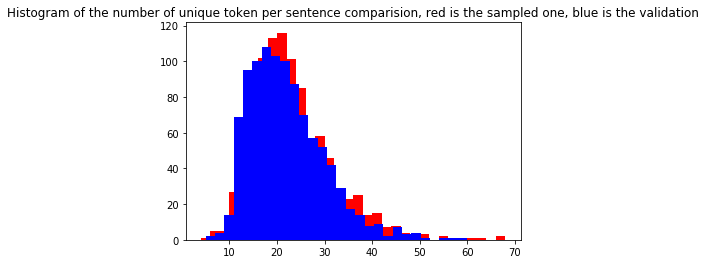

In [0]:
# the plot of the number of unique token per sentence
_ = plt.hist(un_token_list_sampling, bins='auto',color='red')
_ = plt.hist(un_token_list_val, bins='auto',color='blue')
plt.title("Histogram of the number of unique token per sentence comparision, red is the sampled one, blue is the validation")

Text(0.5, 1.0, 'Histogram of the sentence length comparision, red is the sampled one, blue is the validation')

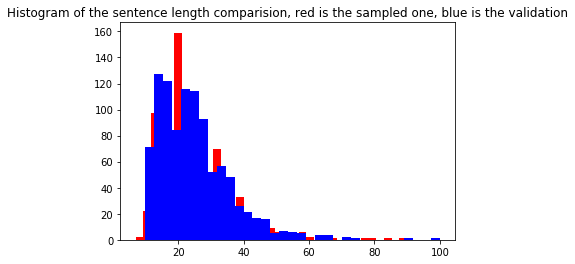

In [0]:
# the plot of sentence length 
_ = plt.hist(sen_len_list_sampling, bins='auto',color='red')
_ = plt.hist(sen_len_list_val, bins='auto',color='blue')
plt.title("Histogram of the sentence length comparision, red is the sampled one, blue is the validation")

#### II.4.4 Example Samples

In [0]:
random_index_list_sampling_example = random.sample(range(len(sampling_sentence_list)),3)

for ind in random_index_list_sampling_example:
  print(wiki_dict.decode_idx_seq(sampling_sentence_list[ind]))


['<bos>', 'He', 'has', 'decided', 'to', 'recognise', 'his', 'ashes', 'over', 'competition', 'and', 'convinced', 'that', 'he', 'and', 'his', 'friends', 'Scout', 'was', 'changed', '.', '<eos>']
['<bos>', 'The', 'house', 'was', 'based', 'on', 'a', 'commercial', 'site', 'being', 'founded', 'by', 'a', 'long', 'farming', ',', 'attracting', 'intentionally', 'to', 'investigate', 'with', 'its', 'diversity', 'after', 'the', 'docks', 'of', '<unk>', '.', '<eos>']
['<bos>', 'Barrow', 'and', 'children', 'appear', 'in', 'the', 'Ottawa', 'story', 'and', 'had', 'to', 'not', 'allow', 'the', 'script', 'to', 'feature', 'in', 'online', 'making', 'his', 'own', 'studio', 'decisive', 'video', 'album', '—', 'and', 'the', 'same', 'Dynamic', 'as', 'Maurice', 'Yeah', '(', '96', '/', '920', ')', '.', '<eos>']


It is quite obvious that these sentences are genetated by the model. They may not stay in the same topic. They are grammerly reasonable in general. 